# Data Validation of Downtown Bluetooth Readings

## Directional Mismatch
Replication of @radumas earlier analysis of directional mismatch on the Gardiner. 

In [3]:
%matplotlib inline
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas.io.sql as pandasql
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [4]:
# setting up pgsql connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [5]:
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional')
direction_obs = pandasql.read_sql(sql, con)

NOTE: Oneway streets are ommitted from the `ryu4.aggr_bt_directional` table. Values produced by the chart are from the entirety of September and October

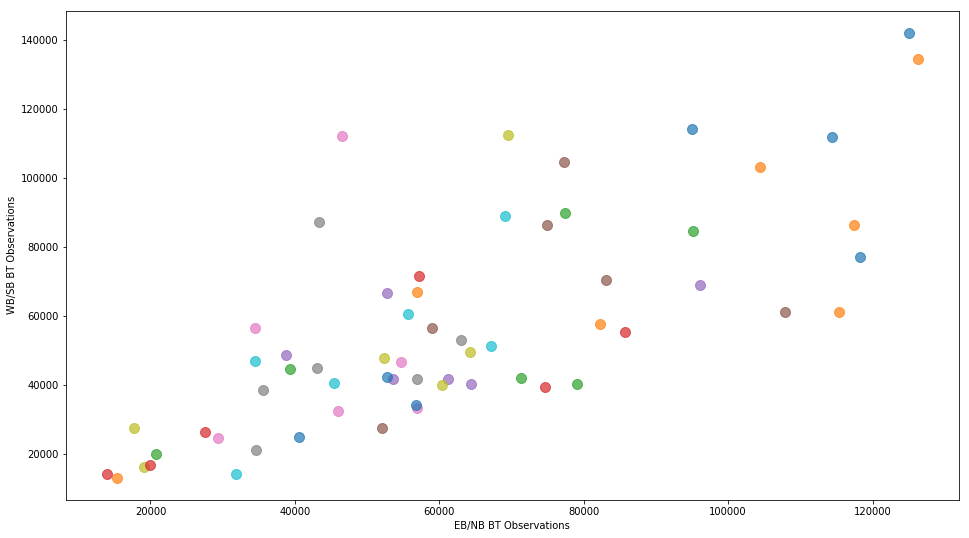

In [6]:
groups = direction_obs.groupby('sb_wb_report_name')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (sb_wb_report_name, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=sb_wb_report_name, linestyle='')

The scatterplot shows WB/SB observations of a route compared to their repsective EB/NB BT observations. As you can see, a few of the routes aren't 1:1.

In [7]:
sql = '''SELECT sb_wb_report_name AS "EB/NB Route Name", \
        nb_eb_report_name AS "WB/SB Route Name", \
        eb_nb_obs AS "Number EB/NB obs", \
        wb_sb_obs AS "Number WB/SB obs", \
        eb_nb_obs - wb_sb_obs AS "EB/NB-WB/SB" \
        FROM ryu4.aggr_bt_directional
        ORDER BY "EB/NB-WB/SB";'''
print_table(sql, con)

EB/NB Route Name,WB/SB Route Name,Number EB/NB obs,Number WB/SB obs,EB/NB-WB/SB
DT-0127. Jarvis-SB_King-to-Front,DT-0129. Jarvis-NB_King-to-Queen,46544.0,112123.0,-65579.0
DT-0110. University-SB_Dundas-to-Queen,DT-0117. University-NB_Queen-to-Dundas,43325.0,87236.0,-43911.0
DT-0111. University-SB_Queen-to-King,DT-0116. University-NB_King-to-Queen,69504.0,112529.0,-43025.0
DT-0104. Spadina-SB_Front-to-Bremner,DT-0105. Spadina-NB_Bremner-to-Front,77243.0,104574.0,-27331.0
DT-0109. University-SB_College-to-Dundas,DT-0118. University-NB_Dundas-to-College,34472.0,56424.0,-21952.0
DT-0112. University-SB_King-to-Front,DT-0115. University-NB_Front-to-King,69135.0,88838.0,-19703.0
DT-0029. Queen-WB_Parliament-to-Jarvis,DT-0026. Queen-EB_Jarvis-to-Parliament,94962.0,114189.0,-19227.0
DT-0134. Parliament-SB_King-to-Front,DT-0135. Parliament-NB_Front-to-King,125017.0,142049.0,-17032.0
DT-0121. Yonge-SB_King-to-Front,DT-0122. Yonge-NB_Front-to-King,57232.0,71542.0,-14310.0
DT-0125. Jarvis-SB_Dundas-to-Queen,DT-0130. Jarvis-NB_Queen-to-Dundas,52718.0,66603.0,-13885.0


The chart above shows each route's EB/NB and WB/SB observation counts for Sept-Oct in addition to EB/NB-WB/SB observations. All route observations are not 1:1 with both directions which is expected. However, these differences are fairly high for both directions and there are many factors which may be influencing them. Lowering the range and taking data that is more recent may produce better results.

In [8]:
# select one week of data between '2017-10-27 00:00:00' and '2017-11-01 00:00:00'
sql = pg.SQL('SELECT * FROM ryu4.aggr_bt_directional_oneweek')
direction_obs_oneweek = pandasql.read_sql(sql, con)

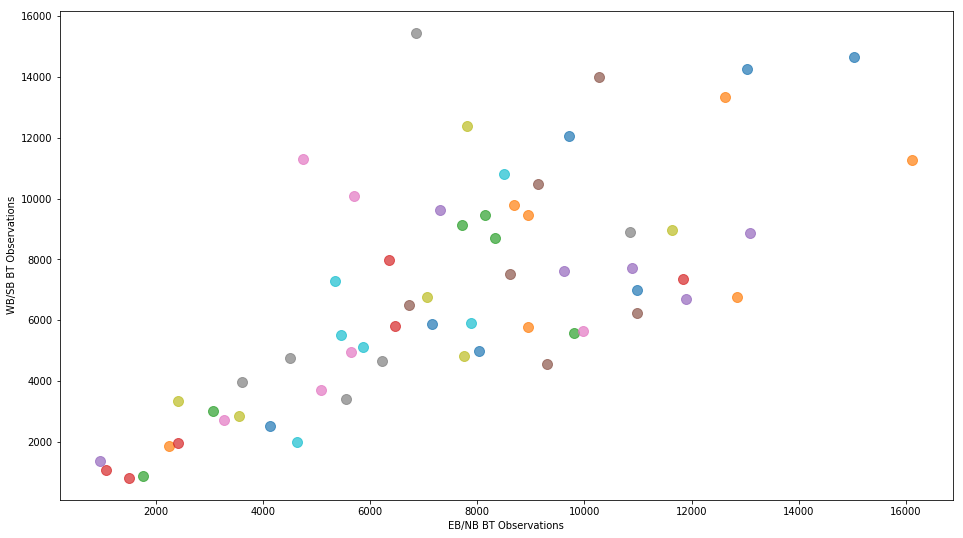

In [9]:
groups = direction_obs_oneweek.groupby('sb_wb_report_name')
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.set_xlabel('EB/NB BT Observations')
ax.set_ylabel('WB/SB BT Observations')
for i, (sb_wb_report_name, data) in enumerate(groups):
    ax.plot(data.eb_nb_obs, data.wb_sb_obs, marker='o', markersize=10, alpha=0.7, label=sb_wb_report_name, linestyle='')

Not much has changed between the 2-month interval graph and the 1-week interval graph. Since not much has changed, a focus is given on the top/bottom routes with largest difference between EB/NB and WB/SB.

In [14]:
sql = '''SELECT sb_wb_report_name AS "EB/NB Route Name", \
        nb_eb_report_name AS "WB/SB Route Name", \
        eb_nb_obs AS "Number EB/NB obs", \
        wb_sb_obs AS "Number WB/SB obs", \
        eb_nb_obs - wb_sb_obs AS "EB/NB-WB/SB" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY "EB/NB-WB/SB"
        LIMIT 10;'''
print_table(sql, con)

EB/NB Route Name,WB/SB Route Name,Number EB/NB obs,Number WB/SB obs,EB/NB-WB/SB
DT-0110. University-SB_Dundas-to-Queen,DT-0117. University-NB_Queen-to-Dundas,6861.0,15451.0,-8590.0
DT-0127. Jarvis-SB_King-to-Front,DT-0129. Jarvis-NB_King-to-Queen,4746.0,11302.0,-6556.0
DT-0111. University-SB_Queen-to-King,DT-0116. University-NB_King-to-Queen,7799.0,12377.0,-4578.0
DT-0109. University-SB_College-to-Dundas,DT-0118. University-NB_Dundas-to-College,5704.0,10083.0,-4379.0
DT-0104. Spadina-SB_Front-to-Bremner,DT-0105. Spadina-NB_Bremner-to-Front,10265.0,14000.0,-3735.0
DT-0029. Queen-WB_Parliament-to-Jarvis,DT-0026. Queen-EB_Jarvis-to-Parliament,9718.0,12067.0,-2349.0
DT-0125. Jarvis-SB_Dundas-to-Queen,DT-0130. Jarvis-NB_Queen-to-Dundas,7308.0,9632.0,-2324.0
DT-0112. University-SB_King-to-Front,DT-0115. University-NB_Front-to-King,8496.0,10807.0,-2311.0
DT-0028. Queen-WB_Broadview-to-Parliament,DT-0027. Queen-EB_Parliament-to-Broadview,5344.0,7284.0,-1940.0
DT-0121. Yonge-SB_King-to-Front,DT-0122. Yonge-NB_Front-to-King,6357.0,7967.0,-1610.0


Bottom 10

In [15]:
sql = '''SELECT sb_wb_report_name AS "EB/NB Route Name", \
        nb_eb_report_name AS "WB/SB Route Name", \
        eb_nb_obs AS "Number EB/NB obs", \
        wb_sb_obs AS "Number WB/SB obs", \
        eb_nb_obs - wb_sb_obs AS "EB/NB-WB/SB" \
        FROM ryu4.aggr_bt_directional_oneweek
        ORDER BY "EB/NB-WB/SB" desc
        LIMIT 10;'''
print_table(sql, con)

EB/NB Route Name,WB/SB Route Name,Number EB/NB obs,Number WB/SB obs,EB/NB-WB/SB
DT-0061. King-WB_Yonge-to-University,DT-0054. King-EB_University-to-Yonge,12852.0,6764.0,6088.0
DT-0014. Dundas-WB_Yonge-to-University,DT-0009. Dundas-EB_University-to-Yonge,11904.0,6706.0,5198.0
DT-0095. Bathurst-SB_Front-to-FortYork,DT-0096. Bathurst-NB_FortYork-to-Front,16115.0,11252.0,4863.0
DT-0126. Jarvis-SB_Queen-to-King,DT-0128. Jarvis-NB_Front-to-King,10985.0,6226.0,4759.0
DT-0015. Dundas-WB_University-to-Spadina,DT-0008. Dundas-EB_Spadina-to-University,9310.0,4569.0,4741.0
DT-0013. Dundas-WB_Jarvis-to-Yonge,DT-0010. Dundas-EB_Yonge-to-Jarvis,11834.0,7362.0,4472.0
DT-0016. Dundas-WB_Spadina-to-Bathurst,DT-0007. Dundas-EB_Bathurst-to-Spadina,9977.0,5644.0,4333.0
DT-0012. Dundas-WB_Parliament-to-Jarvis,DT-0011. Dundas-EB_Jarvis-to-Parliament,9812.0,5567.0,4245.0
DT-0033. Queen-WB_Spadina-to-Bathurst,DT-0022. Queen-EB_Bathurst-to-Spadina,13094.0,8854.0,4240.0
DT-0060. King-WB_Jarvis-to-Yonge,DT-0055. King-EB_Yonge-to-Jarvis,10980.0,7001.0,3979.0


Top 10